# Lab 3 - BCC406/PCC177

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Regressão Logística com multilayer

### Prof. Eduardo e Prof. Pedro

Objetivos:

- Regressão Logística.

Data da entrega : 31/10

- Complete o código (marcado com 'ToDo') e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-LabX.pdf"
- Envie o PDF via google [FORM](https://forms.gle/2trVuvjJPfdKEnjr8)
- Envie o *.ipynb* também.



## Classificador Binário com Regressão Logística

Você criará um classificador baseado em regressão logística para reconhecer gatos em imagens. Contudo, diferente da última prática, você fará uma arquitetura multilayer.

**Dica:**
  - Evite loops (for / while) em seu código. Isso o tornará mais eficiente.
  - Use o código da última prática.

**Notebook para:**
- Construir a arquitetura geral de um algoritmo regressão logística, incluindo:
     - Inicializando parâmetros
     - Cálculo da função de custo e seu gradiente
     - Cálculo para uma arquitetura multilayer.


### Preparação do ambiente

Primeiro precisamos importar os pacotes. Vamos executar a célula abaixo para importar todos os pacotes que precisaremos.
- [*numpy*](www.numpy.org) é o pacote fundamental para a computação científica com Python.
- [*h5py*](http://www.h5py.org) é um pacote comum para interagir com um conjunto de dados armazenado em um arquivo H5.
- [*matplotlib*](http://matplotlib.org) é uma biblioteca famosa para plotar gráficos em Python.
- [*PIL*](http://www.pythonware.com/products/pil/) e [*scipy*](https://www.scipy.org/) são usados aqui para carregar as imagens e testar seu modelo final.
- *np.random.seed(1)* é usado para manter todas as chamadas de funções aleatórias.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

O próximo passo é configurar o *matplotlib* e a geração de valores aleatórios.

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

Configurando o Google Colab.

In [3]:
# Você vai precisar fazer o upload dos arquivos no seu drive (faer na pasta raiz) e montá-lo
# não se esqueça de ajustar o path para o seu drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Carregando e préprocessamento dos dados

In [4]:
# Função para ler os dados (gato/não-gato)
def load_dataset():
    def _load_data():
      train_dataset = h5py.File('drive/MyDrive/train_catvnoncat.h5', "r")
      train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
      train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

      test_dataset = h5py.File('drive/MyDrive/test_catvnoncat.h5', "r")
      test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
      test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

      classes = np.array(test_dataset["list_classes"][:]) # the list of classes
      train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
      test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

      return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

    def _preprocess_dataset(_treino_x_orig, _teste_x_orig):
      # Formate o conjunto de treinamento e teste dados de treinamento e teste para que as imagens
      # de tamanho (num_px, num_px, 3) sejam vetores de forma (num_px * num_px * 3, 1)
      _treino_x_vet = _treino_x_orig.reshape(_treino_x_orig.shape[0], -1) # ToDo: vetorizar os dados de treinamento aqui
      _teste_x_vet = _teste_x_orig.reshape(_teste_x_orig.shape[0], -1) # ToDo: vetorizar os dados de teste aqui

      # Transpor os dados vetorizados
      #_treino_x_vet = _treino_x_vet.T
      #_teste_x_vet = _teste_x_vet.T

      # Normalize os dados (colocar no intervalo [0.0, 1.0])
      _treino_x = _treino_x_orig/255. # ToDo: normalize os dados de treinamento aqui
      _teste_x = _teste_x_orig/255. # ToDo: normalize os dados de teste aqui
      return _treino_x, _teste_x

    _treino_x_orig, treino_y, _teste_x_orig, teste_y, classes = _load_data()
    treino_x, teste_x = _preprocess_dataset(_treino_x_orig, _teste_x_orig)
    return treino_x, treino_y, teste_x, teste_y, classes

Carregando os dados

In [5]:
# Lendo os dados (gato/não-gato)
treino_x, treino_y, teste_x, teste_y, classes = load_dataset()

### Criando funções auxiliares (10pt)

Agora que entendemos a arquitetura da rede multicamadas (uma camada de entrada, *L* camadas ocultas e uma camada de saída), precisamos criar as funções auxiliares para treinar o modelo. Observe que todas as funções já foram implementadas por você na última prática, logo você somente precisará fazer uma adaptação.



#### Inicialização dos pesos (5pt)

O modelo precisa que os seus pesos sejam inicializados. Essa inicialização pode ser feita gerando os pesos aleatoriamente ou com valores zerados dada uma dimensão.

Para testarmos, começaremos inicializando o vetor $w$ e $b$ como zero dada uma dimensão `dim`.

In [6]:
# Função que inicializa w e b
#   **dica**: veja a função np.zeros(..)

def inicialize_parametros(camadas_dims):
    """
    Inicializa um vetor de vetores para w e b.

    Entrada:
      camadas_dims -- lista contendo a dimensão de cada camada da rede.
    Saída:
      parametros   -- python dicionario contendo os parametros "W1", "b1", ..., "WL", "bL":
      Wl -- vetor de pesos com formato (camadas_dims[l], camadas_dims[l-1])
      bl -- vetor de vies com formato (camadas_dims[l], 1)
    """

    parametros = {}
    L = len(camadas_dims) # ToDo: número de camadas da rede

    for l in range(1, L):
      #   **dica**: itere pelo número de camadas, inicializando com pesos zerados e viés zerado
      #             de cada camada, e armazenem em parameters
      parametros[f'W{l}'] = np.zeros((camadas_dims[l], camadas_dims[l-1])) # ToDo: W deve estar no formato (camadas_dims[l], camadas_dims[l-1])
      parametros[f'b{l}'] = np.zeros((camadas_dims[l], 1)) # ToDo: b deve estar no formato (camadas_dims[l], 1)

    return parametros

Agora vamos testar a função `inicialize()`. Primeiro, certifique-se de que as dimensões entre cada camada estejam corretas. Lembre-se de que $n^{[l]}$ é o número de unidades na camada $l$. Assim, por exemplo, se o tamanho da nossa entrada $X$ for $(12288, 209)$ (com número de exemplos $m=209$), então:

<table style="width:100%">
  <tr>
     <td>  </td>
     <td> <b>Formato de <em>W</em></b> </td>
     <td> <b>Formato de <em>b</em></b> </td>
     <td> <b>Cálculo da Ativação em cada camada</b> </td>
     <td> <b>Formato da Ativação</b> </td>
  </tr>
  <tr>
     <td> <b>Camada 1</b> </td>
     <td> $(n^{[1]},12288)$ </td>
     <td> $(n^{[1]},1)$ </td>
     <td> $Z^{[1]}=W^{[1]}X+b^{[1]}$ </td>
     <td> $(n^{[1]},209)$ </td>
  </tr>
  <tr>
     <td> <b>Camada 2</b> </td>
     <td> $(n^{[2]}, n^{[1]})$  </td>
     <td> $(n^{[2]},1)$ </td>
     <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td>
     <td> $(n^{[2]}, 209)$ </td>
  </tr>
  <tr>
     <td> $\vdots$ </td>
     <td> $\vdots$  </td>
     <td> $\vdots$  </td>
     <td> $\vdots$</td>
     <td> $\vdots$  </td>
  </tr>
  <tr>
     <td> <b>Camada L-1</b> </td>
     <td> $(n^{[L-1]}, n^{[L-2]})$ </td>
     <td> $(n^{[L-1]}, 1)$  </td>
     <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td>
     <td> $(n^{[L-1]}, 209)$ </td>
  </tr>
  <tr>
     <td> <b>Camada L</b> </td>
     <td> $(n^{[L]}, n^{[L-1]})$ </td>
     <td> $(n^{[L]}, 1)$ </td>
     <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
     <td> $(n^{[L]}, 209)$  </td>
  </tr>
</table>

Para testar a sua função, criaremos uma arquitetura com 3 camadas: 5, 4 e 3.

Os valores esperados são:

```python
W1 = [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
b2 = [[0.]
 [0.]
 [0.]]
```

In [7]:
parametros = inicialize_parametros([5,4,3])
print(f'W1 = {parametros["W1"]}')
print(f'b1 = {parametros["b1"]}')
print(f'W2 = {parametros["W2"]}')
print(f'b2 = {parametros["b2"]}')

W1 = [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
b2 = [[0.]
 [0.]
 [0.]]


#### Funções de Ativação

Nessa prática serão usadas duas funções de ativação: *Sigmoid* e *ReLU*. Ambas já estão implementadas.

*Sigmoid*

In [8]:
def sigmoid(Z):
    """
    Implementa a função de ativação sigmoid em numpy.

    Entrada:
      Z -- array numpy de qualquer formato
    Saída:
      A -- saída da sigmoid(z) (mesmo formato de Z)
      cache -- retorna Z também (útil durante o backpropagation)
    """
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def sigmoid_backward(dA, cache):
    """
    Implementa a retropropagação para uma única unidade Sigmoid.

    Entrada:
      dA -- gradiente pós-ativação de qualquer formato
      cache -- 'Z' onde armazenamos para calcular a propagação retroativa de forma eficiente
    Saída:
      dZ -- Gradiente do custo em relação a Z
    """
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)

    return dZ

*ReLU*

In [9]:
def relu(Z):
    """
    Implementa a função ReLU em numpy.

    Eentrada:
      Z -- array numpy de qualquer formato
    Saída:
      A -- Parâmetro pós-ativação, do mesmo formato de Z
      cache -- um dicionário python contendo "A" (armazenado para calcular o passe para trás de forma eficiente)
    """
    A = np.maximum(0,Z)
    cache = Z
    assert(A.shape == Z.shape)
    return A, cache

def relu_backward(dA, cache):
    """
    Implementa a retropropagação para uma única unidade ReLU.

    Entrada:
      dA -- gradiente pós-ativação de qualquer formato
      cache -- 'Z' onde armazenamos para calcular a propagação retroativa de forma eficiente
    Saída:
      dZ -- Gradiente do custo em relação a Z
    """
    Z = cache
    dZ = np.array(dA, copy=True) # somente convertendo dz para o objeto correto.
    # Quando z <= 0, você deveria setar dz para 0 também.
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)

    return dZ

#### Função de custo (5pt)

O objetivo da função de custo é calcular o erro ou a discrepância entre o que foi predito e o valor real.

Como já foi visto, você precisa calcular

$$J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}).$$

In [10]:
# Faça a função para calcular o custo J
#   **dica**: você pode usar a função np.log(..)

def calcula_custo(AL, Y):
    """
    Calcula o custo J considerando Y e A.

    Entrada:
      AL -- Probabiliade de predição da rede, (1, numero de exemplos)
      Y -- Vetor de rótulos dos exemplos de treinamento  ( 0 se não tem gato, 1 tem gato ), (1, numero de exemplos)
    Saída:
      custo -- custo da rede
    """

    m = Y.shape[1] # número de exemplos
    custo = - (1/m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL)) # ToDo: implemente a função de custo J. **dica** : utilize a função np.log() e np.dot
    custo = np.squeeze(custo) # assegurar o formato experado ( [[17]] para 17).
    return custo

Agora vamos testar a função `calcula_custo()`. Para isso, testaremos com `Y` (1, 1 e 0) e para `AL` (0.8, 0.9 e 0.4). O valor esperado é de 0.2797765635793422.




In [11]:
Y = np.asarray([[1, 1, 0]])
AL = np.array([[0.8, 0.9, 0.4]])

print(f'custo([1, 1, 0], [0.8, 0.9, 0.4]) = {calcula_custo(AL, Y)}')

custo([1, 1, 0], [0.8, 0.9, 0.4]) = 0.2797765635793422


### Fase 1: *Forward* (propagação) dos valores pelo modelo (30pt)

Para realizar a propagação da imagem pela rede é necessário passar por cada camada. Para isso, usaremos três funções, uma para realizar a propagação em uma camada (`linear_forward`), uma para aplicar a ativação (`linear_ativacao_forward`) e outra função para gerenciar a propagação por cada rede (`L_modelo_forward`).

#### Linear *Forward* (10pt)

A função linear_forward (sobre todos os examples) é definida pela equação:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

onde $A^{[0]} = X$.


**Lembrete**
Lembre-se de que quando calculamos $ W X + b $ em python, ele realiza `broadcasting`. Por exemplo, se:
$$ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}\tag{2}$$

Então $WX + b$ será:

$$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}\tag{3}  $$

In [12]:
def linear_forward(A, W, b):
    """
    Implementa a parte linear da fase de propogação nas camadas

    Entradas:
      A - dados de entrada da camada atual (ativações da camada anterior): formato (tamanho da camada anterior, número de exemplos)
      W - matriz de pesos: matriz numpy com formato (tamanho da camada atual, tamanho da camada anterior)
      b - vetor de viés, matriz numpy com formato (tamanho da camada atual, 1)
    Saídas:
      Z -- a entrada da função de ativação, também chamada de parâmetro de pré-ativação
      cache - uma tupla python contendo "A", "W" e "b"; (armazenado para usar na fase backward propagation)
    """
    Z = np.dot(W, A) + b # ToDo: propague A utilizando os pesos W e o bias b. **dica**: use a funçao np.dot()
    cache = (A, W, b)

    return Z, cache

Testando a função de `linear_forward`. Valores Esperados:

<table style="width:35%">
  <tr>
    <td> <b>Z</b> </td>
    <td> [[ 3.26295337 -1.23429987]] </td>
  </tr>
</table>



In [13]:
A = np.array([[1.62434536, -0.61175641], [-0.52817175, -1.07296862], [0.86540763, -2.3015387]])
W = np.array([[1.74481176, -0.7612069, 0.3190391]])
b = np.array([[-0.24937038]])

Z, linear_cache = linear_forward(A, W, b)

print(f'Z = {Z}')

Z = [[ 3.26295336 -1.23429988]]


#### Linear-Ativação *Forward* (10pt)

Usaremos duas funções de ativação:

- **Sigmoid**:
>$$\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$$
A função `sigmoid`, **retorna dois** itens: o valor de ativação "` a` "e um" `cache`" que contém "` Z` "(necessário para a fase backward correspondente). Para usá-lo, basta chamar:
``` python
A, ativacao_cache = sigmoid(Z)
```

- **ReLU**:
> $$A = RELU(Z) = max(0, Z)$$
A função `relu`, **retorna dois** itens: o valor de ativação "` a` "e um" `cache`" que contém "` Z` "(necessário para a fase backward correspondente). Para usá-lo, basta chamar:
``` python
A, ativacao_cache = relu(Z)
```

Implemente a *LINEAR-> ATIVAÇÃO* da camada da fase forward propagation. A relação matemática é: $ A^{[l]} = g (Z^{[l]}) = g (W^{[l]} A^{[l-1]} + b^{[l]} ) $ onde a ativação "g" pode ser `sigmoid` ou `relu`. Use a função linear_forward ().

In [14]:
def linear_ativacao_forward(A_prev, W, b, ativacao):
    """
    Implementa a *LINEAR-> ATIVAÇÃO* da camada da fase forward propagation

    Entradas:
      A_prev -- dados de entrada da camada atual (ativações da camada anterior): formato (tamanho da camada anterior, número de exemplos)
      W - matriz de pesos: matriz numpy com formato (tamanho da camada atual, tamanho da camada anterior)
      b - vetor de viés, matriz numpy com formato (tamanho da camada atual, 1)
      ativacao -- "sigmoid" ou "relu"
    Saídas:
      A -- a saída da função de ativação, também chamada de valor da pós-ativação
      cache -- uma tupla python contendo "linear_cache" e "ativacao_cache";
      (armazenado para usar na fase backward propagation)
    """

    Z, linear_cache = linear_forward(A_prev, W, b) # ToDo: propagar A_prev pela camada com pesos W e bias b
    # **dicas**: use sua funcao de propagação e as funções de ativação fornecidas
    if ativacao == "sigmoid":
        A, activation_cache = sigmoid(Z) # ToDo: Função sigmoid
    elif ativacao == "relu":
        A, activation_cache = relu(Z) # ToDo: Função ReLU
    cache = (linear_cache, activation_cache)

    return A, cache

Testando a função de `linear_ativacao_forward`. Valores Esperados:

<table style="width:35%">
  <tr>
    <td> <b>sigmoid(A)</b> </td>
    <td > [[ 0.96890023  0.11013289]]</td>
  </tr>
  <tr>
    <td> <b>ReLU(A)</br> </td>
    <td> [[ 3.43896131  0.        ]]</td>
  </tr>
</table>



In [15]:
A_prev = np.array([[-0.41675785, -0.05626683], [-2.1361961, 1.64027081], [-1.79343559, -0.84174737]])
W = np.array([[0.50288142, -1.24528809, -1.05795222]])
b = np.array([[-0.90900761]])

A, linear_ativacao_cache = linear_ativacao_forward(A_prev, W, b, ativacao = "sigmoid")
print(f'sigmoid(A) = {A}')
A, linear_ativacao_cache = linear_ativacao_forward(A_prev, W, b, ativacao = "relu")
print(f'com ReLU(A) = {A}')

sigmoid(A) = [[0.96890023 0.11013289]]
com ReLU(A) = [[3.43896134 0.        ]]


#### Modelo de L-camadas (10pt)

Replica a função `linear_ativacao_forward` com RELU $(L-1)$ vezes, depois uma vez `linear_ativacao_forward` com SIGMOID.

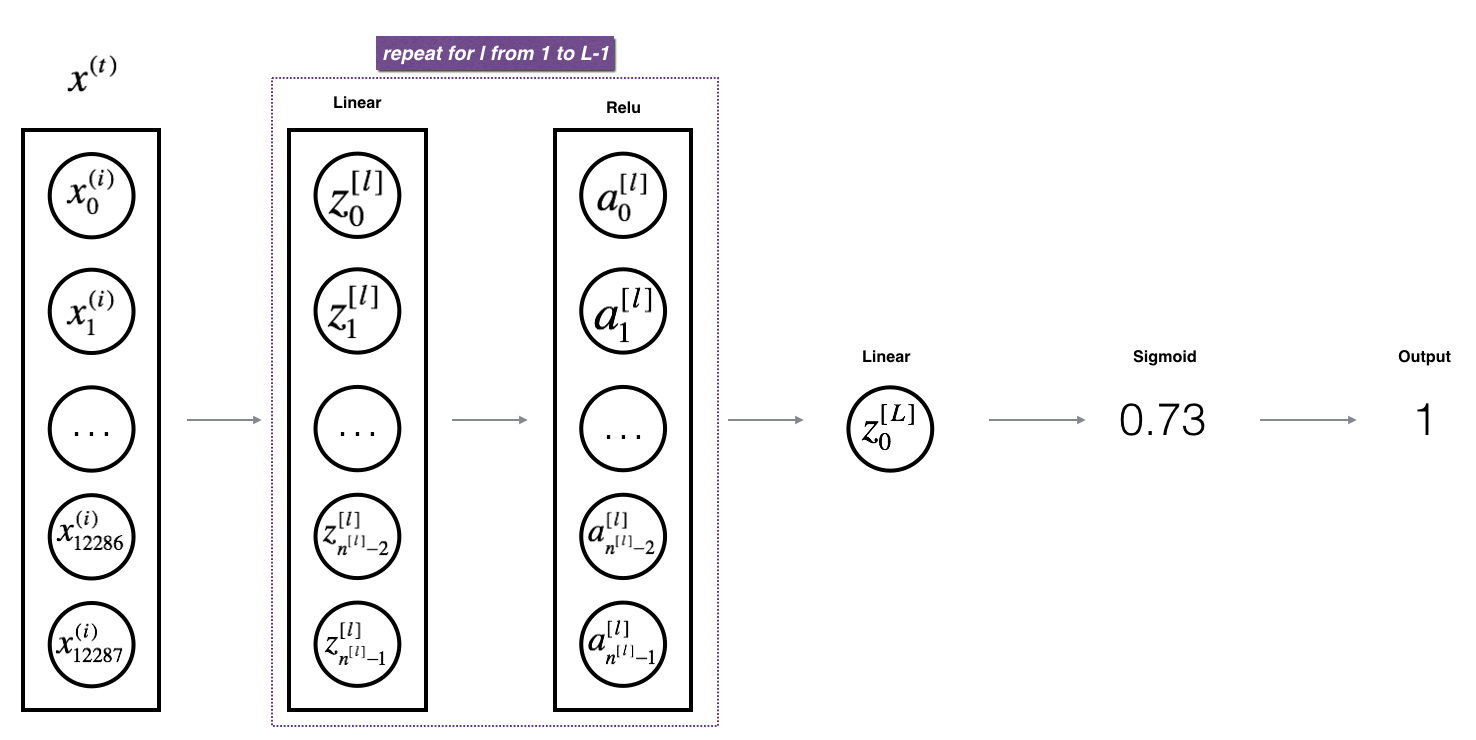

<caption><center> Figura: Esquema do modelo *[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* </center></caption><br>

**Instrução**: A variável `AL` é $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (ativaçnao da última camada, i.e., $\hat{Y}$.)

In [16]:
def L_modelo_forward(X, parametros):
    """
    Implementa a fase forward propagation

    Entradas:
      X -- dados, numpy array de tamanho (input size, number of examples)
      parametros -- parametros iniciais

    Saídas:
      AL -- valor da pós-ativação da última camada
      caches -- lista dos caches contendo:
                todos caches da linear_ativacao_forward() (existem L-1 deles, indexados de 1 a L-1)
    """

    caches = []
    A = X # ToDo: dados da camada inicial.
    L = len(parametros) // 2 # Números de camadas da rede

    for l in range(1, L):
        A_prev = A
        A, cache = linear_ativacao_forward(A_prev, parametros[f'W{l}'], parametros[f'b{l}'], "relu") # ToDo: propagar o dado e calcular ativação. **dica** utilize linear_activation_forward(), relu e parametros
        caches.append(cache)

    AL, cache = linear_ativacao_forward(A, parametros[f'W{L}'], parametros[f'b{L}'], "sigmoid")
 # ToDo: propagar o dado e calcular ativação da ultima camada. **dica** utilize linear_activation_forward(), sigmoid e parametros
    caches.append(cache)

    return AL, caches

Agora vamos testar a função `L_modelo_forward()`. Para isso, consideraremos os seguintes formatos:
```
   W1 = (4,5)
   b1 = (4,1)
   W2 = (3,4)
   b2 = (3,1)
   W3 = (1,3)
   b3 = (1,1)
```

Os valores esperados são:

<table style="width:50%">
  <tr>
    <td> <b>AL</b> </td>
    <td > [[ 0.03921668  0.70498921  0.19734387  0.04728177]]</td>
  </tr>
  <tr>
    <td> <b>Tamanho da lista caches</b> </td>
    <td > 3 </td>
  </tr>
</table>

In [17]:
np.random.seed(6)
X = np.array([[-0.31178367, 0.72900392, 0.21782079, -0.8990918],
              [-2.48678065, 0.91325152, 1.12706373, -1.51409323],
              [1.63929108, -0.4298936, 2.63128056, 0.60182225],
              [-0.33588161, 1.23773784, 0.11112817, 0.12915125],
              [0.07612761, -0.15512816, 0.63422534, 0.810655]])

parametros = {'W1': np.array([[ 0.35480861,  1.81259031, -1.3564758 , -0.46363197,  0.82465384],
                              [-1.17643148,  1.56448966,  0.71270509, -0.1810066 ,  0.53419953],
                              [-0.58661296, -1.48185327,  0.85724762,  0.94309899,  0.11444143],
                              [-0.02195668, -2.12714455, -0.83440747, -0.46550831,  0.23371059]]),
              'b1': np.array([[ 1.38503523], [-0.51962709], [-0.78015214], [ 0.95560959]]),
              'W2': np.array([[-0.12673638, -1.36861282,  1.21848065, -0.85750144],
                              [-0.56147088, -1.0335199 ,  0.35877096,  1.07368134],
                              [-0.37550472,  0.39636757, -0.47144628,  2.33660781]]),
              'b2': np.array([[ 1.50278553], [-0.59545972], [ 0.52834106]]),
              'W3': np.array([[ 0.9398248 ,  0.42628539, -0.75815703]]),
              'b3': np.array([[-0.16236698]])}

AL, caches = L_modelo_forward(X, parametros)

print("AL = " + str(AL))
print("Tamanho da lista caches = " + str(len(caches)))

AL = [[0.03921668 0.70498921 0.19734387 0.04728177]]
Tamanho da lista caches = 3


### Fase 2: *Backward* (retropropagação) dos valores pelo modelo (40pt)

Com funções auxiliares, a fase back propagation é usada para calcular o gradiente da função loss em relação aos parâmetros.

**Lembrete**:
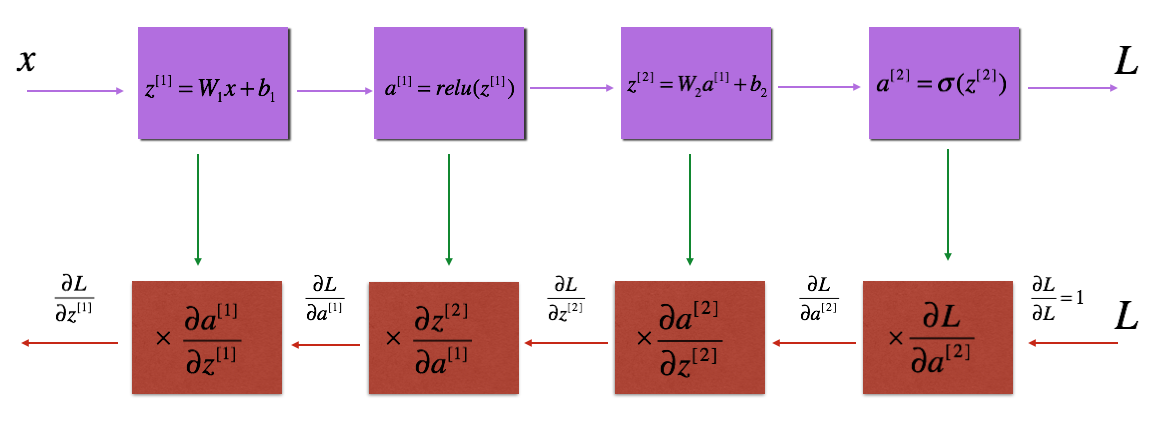

<caption><center> Figura: <br> *Os blocos roxos representam a fase forward propagation, e os vermelhos representam a fase backward propagation.*  </center></caption>

Usaremos duas funções, igualmente feito na fase forward:
- LINEAR
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID

#### Linear *backward* (10pt)

Para a camada $l$, a parte linear é:
$$Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$$ (seguida por uma ativação)

Suponha que
$$dZ^{[l]} = \frac{\partial L }{\partial Z^{[l]}}$$
já foi calculado.

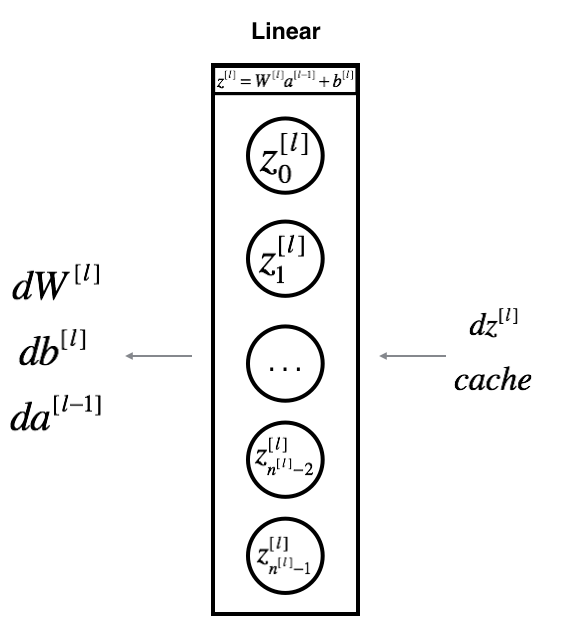

As saídas $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ são calculadas usando $dZ^{[l]}$:
$$ dW^{[l]} = \frac{\partial J}{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$

$$ db^{[l]} = \frac{\partial J }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$

$$ dA^{[l-1]} = \frac{\partial L }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$

In [18]:
# linear_backward

def linear_backward(dZ, cache):
    """
    Implementa a parte linear da fase backward propagation em uma camada l.

    Entradas:
      dZ -- gradiente do custo em relação a saída linear da camada l
      cache -- tupla (A_prev, W, b) vindo da forward propagation da camada l
    Saídas:
      dA_prev -- gradiente do custo em relação a ativação da camada l-1,
      dW -- gradiente do custo em relação a W  da camada l,
      db -- gradiente do custo em relação a b,
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / m # ToDo: Calcular dW. **dica** utilize np.dot
    db = np.sum(dZ, axis=1, keepdims=True) / m # ToDo: Calcular db. **dica** utilize np.sum com axis=1 e keepdims=True
    dA_prev = np.dot(W.T, dZ) # ToDo: Calcule dA_prev baseado em W e dz. **dica** utilize np.dot

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db

Agora vamos testar a função `linear_backward`. Os valores esperados são:
    
```
dA_prev = [[-1.15171336  0.06718465 -0.3204696   2.09812712]
           [ 0.60345879 -3.72508701  5.81700741 -3.84326836]
           [-0.4319552  -1.30987417  1.72354705  0.05070578]
           [-0.38981415  0.60811244 -1.25938424  1.47191593]
           [-2.52214926  2.67882552 -0.67947465  1.48119548]]
dW = [[ 0.07313866 -0.0976715  -0.87585828  0.73763362  0.00785716]
      [ 0.85508818  0.37530413 -0.59912655  0.71278189 -0.58931808]
      [ 0.97913304 -0.24376494 -0.08839671  0.55151192 -0.10290907]]
db = [[-0.14713786]
      [-0.11313155]
      [-0.13209101]]
```

In [19]:
# Teste
np.random.seed(1)
dZ = np.array([[1.62434536, -0.61175641, -0.52817175, -1.07296862], [0.86540763, -2.3015387, 1.74481176, -0.7612069],
               [0.3190391, -0.24937038, 1.46210794, -2.06014071]])

A = np.array([[-0.3224172 , -0.38405435,  1.13376944, -1.09989127],
              [-0.17242821, -0.87785842,  0.04221375,  0.58281521],
              [-1.10061918,  1.14472371,  0.90159072,  0.50249434],
              [ 0.90085595, -0.68372786, -0.12289023, -0.93576943],
              [-0.26788808,  0.53035547, -0.69166075, -0.39675353]])
W = np.array([[-0.6871727 , -0.84520564, -0.67124613, -0.0126646 , -1.11731035],
              [ 0.2344157 ,  1.65980218,  0.74204416, -0.19183555, -0.88762896],
              [-0.74715829,  1.6924546 ,  0.05080775, -0.63699565,  0.19091548]])
b = np.array([[2.10025514], [0.12015895], [0.61720311]])

linear_cache = (A, W, b)
dA_prev, dW, db = linear_backward(dZ, linear_cache)

print(f'dA_prev = {dA_prev}')
print(f'dW = {dW}')
print(f'db = {db}')

dA_prev = [[-1.15171336  0.06718465 -0.32046959  2.09812711]
 [ 0.6034588  -3.72508703  5.81700741 -3.84326836]
 [-0.4319552  -1.30987418  1.72354703  0.05070578]
 [-0.38981415  0.60811244 -1.25938424  1.47191593]
 [-2.52214925  2.67882551 -0.67947465  1.48119548]]
dW = [[ 0.07313866 -0.0976715  -0.87585828  0.73763362  0.00785716]
 [ 0.85508818  0.37530413 -0.59912656  0.71278189 -0.58931808]
 [ 0.97913304 -0.24376493 -0.08839671  0.55151192 -0.10290907]]
db = [[-0.14713785]
 [-0.11313155]
 [-0.13209101]]


#### Linear-Ativação *backward* (10pt)

A etapa backward para a ativação **`linear_ativacao_backward`**.

Use as funções:
- **`sigmoid_backward`**: backward propagation para Sigmoid:

>```python
dZ = sigmoid_backward(dA, ativacao_cache)
```

- **`relu_backward`**: backward propagation para ReLU:

>```python
dZ = relu_backward(dA, ativacao_cache)
```

Se $g(.)$ é a função de ativação,
`sigmoid_backward` e `relu_backward` calcula
$$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}) \tag{11}$$



In [20]:
def linear_ativacao_backward(dA, cache, ativacao):
    """
    Implementa a backward propagation para ativação.

    Entradas:
      dA -- gradiente da pos-ativacao gradient para camada l
      cache -- tupla de valores (linear_cache, ativacao_cache)
      ativacao -- "sigmoid" or "relu"
    Saídas:
      dA_prev -- gradiente do custo em relação a ativação da camada l-1.
      dW -- gradiente do custo em relação a W  da camada l.
      db -- gradiente do custo em relação a b.
    """
    linear_cache, ativacao_cache = cache

    if ativacao == "relu":
        dZ = relu_backward(dA, ativacao_cache) # ToDo: calcular o relu_backward
    elif ativacao == "sigmoid":
        dZ = sigmoid_backward(dA, ativacao_cache) # ToDo: calcular o sigmoid_backward

    dA_prev, dW, db = linear_backward(dZ, linear_cache) # ToDo: calcular o linear_backward

    return dA_prev, dW, db

Agora vamos testar a função `linear_backward`.

Valores esperados para *Sigmoid*:

```
dA_prev = [[ 0.11017994  0.01105339] [ 0.09466817  0.00949723] [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]
```

Valores esperados com *ReLU*:

```
dA_prev = [[ 0.44090989  0.        ] [ 0.37883606  0.        ] [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]
```

In [48]:
dAL = np.array([[-0.41675785, -0.05626683]])
A = np.array([[-2.1361961 ,  1.64027081], [-1.79343559, -0.84174737], [ 0.50288142, -1.24528809]])
W = np.array([[-1.05795222, -0.90900761,  0.55145404]])
b = np.array([[2.29220801]])
Z = np.array([[ 0.04153939, -1.11792545]])
linear_cache = (A, W, b)
activation_cache = Z
linear_ativacao_cache = (linear_cache, activation_cache)

dA_prev, dW, db = linear_ativacao_backward(dAL, linear_ativacao_cache, ativacao="sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = linear_ativacao_backward(dAL, linear_ativacao_cache, ativacao="relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

sigmoid:
dA_prev = [[ 0.11017994  0.0110534 ]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576155]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]

relu:
dA_prev = [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513825  0.37371418 -0.10478989]]
db = [[-0.20837892]]


#### L-Modelo *Backward* (10pt)

A Figura mostra a fase backward.


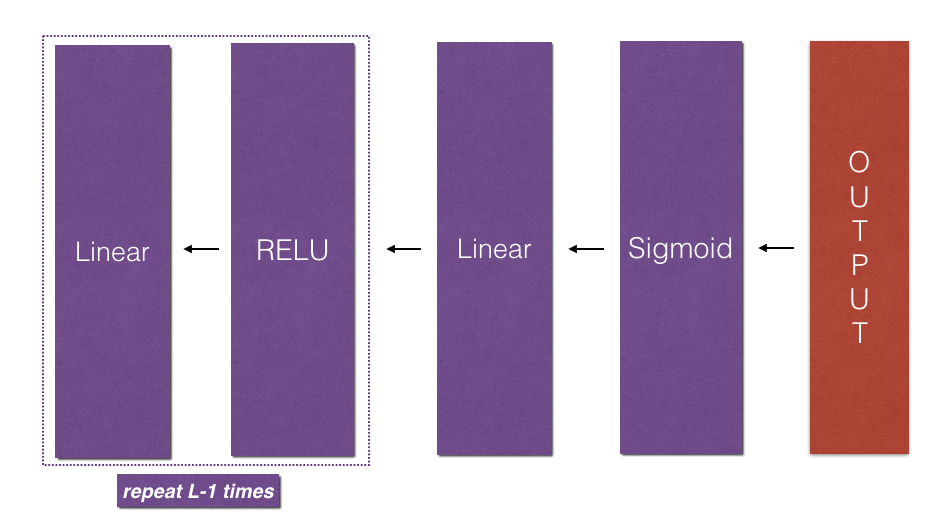
<caption><center>  Figura: Fase Backward  </center></caption>

**Inicializando a fase backpropagation**:
A saída da rede é,
$$A^{[L]} = \sigma(Z^{[L]})$$

Então temos que calcualar `dAL` $= \frac{\partial L}{\partial A^{[L]}}$:

`dAL`  $=\frac{Y}{AL} - \frac{1-Y}{1-Al}$


O gradiente `dAL` para continuar propagando. Como visto na Figura 5, `dAL` vai alimentar a linear_ativacao_backward com ativação SIGMOID (que utilizará os valores armazenados em cache armazenados pela função L_modelo_forward). Depois disso, você terá que usar um loop `for` para percorrer todas as outras camadas usando linear_ativacao_backward com ativação RELU. Você deve armazenar cada dA, dW e db no dicionário grads.


In [53]:
def L_modelo_backward(AL, Y, caches):
    """
    Implementa a backward propagation para [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID

    Entradas:
      AL -- Probabiliade de predição da rede, saída da fase forward propagation (L_modelo_forward())
      Y -- Vetor de rótulos dos exemplos de treinamento  ( 0 se não tem gato, 1 tem gato )
      caches -- lista de caches contendo:
                  todos cache da linear_ativacao_forward() com "relu" ( caches[l], l = 0...L-2)
                  o cache da linear_ativacao_forward() com "sigmoid" (caches[L-1])
    Saídas:
      grads -- Um dicionário com os gradientes
    """
    grads = {}


    L = len(caches) # número de camadas
    m = AL.shape[1] # número de exemplos

    Y = Y.reshape(AL.shape) # Y deve ter o mesmo formato que AL

    # Inicilizando a fase backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # ToDo: gradiente do custo em relação a AL **dica** utilize np.divide

    # gradiente da l-ésima camada (SIGMOID -> LINEAR).
    # Entrada: "dAL, corrente_cache". Saida: "d(AL-1), dWL, dbL"
    current_cache = caches[L - 1] # ToDo: pegar a cache de L - 1
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_ativacao_backward(dAL, current_cache, "sigmoid") # ToDo: chamar a função linear_ativacao_backward e sigmoid


    # Gradientes das camadas anteriores: (RELU -> LINEAR)
    # Entradas: "dA(l+1), corrente_cache".
    # Saídas: "dA(l), dW(l+1), db(l+1)"
    ### Início do código ###
    # Loop de l=L-2 até l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_ativacao_backward(grads["dA" + str(l+1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp



    return grads

Agora vamos testar a função criada. Os valores esperados são:

```
dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
       [0.         0.         0.         0.        ]
       [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
       [ 0.        ]
       [-0.02835349]]
dA1 = [[ 0.          0.52257901]
       [ 0.         -0.3269206 ]
       [ 0.         -0.32070404]
       [ 0.         -0.74079187]]
```

In [54]:
AL = np.array([[1.78862847, 0.43650985]])
Y_teste = np.array([[1, 0]])
A1 = np.array([[ 0.09649747, -1.8634927 ], [-0.2773882,  -0.35475898], [-0.08274148, -0.62700068], [-0.04381817, -0.47721803]])
W1 = np.array([[-1.31386475,  0.88462238,  0.88131804,  1.70957306],
               [ 0.05003364, -0.40467741, -0.54535995, -1.54647732],
               [ 0.98236743, -1.10106763, -1.18504653, -0.2056499 ]])
b1 = np.array([[ 1.48614836], [ 0.23671627], [-1.02378514]])
Z1 = np.array([[-0.7129932,   0.62524497], [-0.16051336, -0.76883635], [-0.23003072,  0.74505627]])
linear_cache_activation_1 = ((A1, W1, b1), Z1)

A2 = np.array([[ 1.97611078, -1.24412333], [-0.62641691, -0.80376609], [-2.41908317, -0.92379202]])
W2 = np.array([[-1.02387576,  1.12397796, -0.13191423]])
b2 = np.array([[-1.62328545]])
Z2 = np.array([[ 0.64667545, -0.35627076]])
linear_cache_activation_2 = ((A2, W2, b2), Z2)

caches = (linear_cache_activation_1, linear_cache_activation_2)
grads = L_modelo_backward(AL, Y_teste, caches)
print(f'dW1 = {grads["dW1"]}')
print(f'db1 = {grads["db1"]}')
print(f'dA1 = {grads["dA1"]}\n')

dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.12913162 -0.44014127]
 [-0.14175655  0.48317296]
 [ 0.01663708 -0.05670697]]



#### Atualização dos parâmetros (10pt)

Usando gradiente descendente tem-se:

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

onde $\alpha$ é a taxa de aprendizagem.

Seu objetivo agora é a atualização dos parâmetros usando gradiente descendente: $W^{[l]}$ and $b^{[l]}$ para $l = 1, 2, ..., L$.


In [55]:
def atualize_parametros(parametros, grads, learning_rate):
    """
    Atualização dos parâmetros usando gradiente descendente:

    Entradas:
    parametros -- python dicionario contendo os parametros
    grads -- python dicionario contendo os gradientes, saída L_modelo_backward

    Saídas:
    parametros -- python dicionario contendo os parametros

    """

    L = len(parametros) // 2  # número de camadas da rede

    # Atualiza os parametros.
    ### Início do código ###
    for l in range(L):
        parametros["W" + str(l+1)] = parametros["W" + str(l+1)] - learning_rate * grads["dW"+ str(l+1)]
        parametros["b" + str(l+1)] = parametros["b" + str(l+1)] - learning_rate * grads["db"+ str(l+1)]
    ### Fim do código ###
    return parametros

Agora vamos testar a função `atualize_parametros`. Os valores esperados são:

```
W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
      [-1.76569676 -0.80627147  0.51115557 -1.18258802]
      [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
      [-1.28888275]
      [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]
```

In [56]:
W1 = np.array([[-0.41675785, -0.05626683, -2.1361961 ,  1.64027081],
               [-1.79343559, -0.84174737,  0.50288142, -1.24528809],
               [-1.05795222, -0.90900761,  0.55145404,  2.29220801]])
b1 = np.array([[ 0.04153939], [-1.11792545], [ 0.53905832]])
W2 = np.array([[-0.5961597 , -0.0191305 ,  1.17500122]])
b2 = np.array([[-0.74787095]])
parametros = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

dW1 = np.array([[ 1.78862847,  0.43650985,  0.09649747, -1.8634927 ],
                [-0.2773882 , -0.35475898, -0.08274148, -0.62700068],
                [-0.04381817, -0.47721803, -1.31386475,  0.88462238]])
db1 = np.array([[0.88131804], [1.70957306], [0.05003364]])
dW2 = np.array([[-0.40467741, -0.54535995, -1.54647732]])
db2 = np.array([[0.98236743]])
grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

parametros = atualize_parametros(parametros, grads, 0.1)

print ("W1 = "+ str(parametros["W1"]))
print ("b1 = "+ str(parametros["b1"]))
print ("W2 = "+ str(parametros["W2"]))
print ("b2 = "+ str(parametros["b2"]))

W1 = [[-0.5956207  -0.09991781 -2.14584585  1.82662008]
 [-1.76569677 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284051  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888276]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


### Construção e teste do modelo (20pt)

Implemente o modelo usando as funções anteriores para treinar os parâmetros da rede no conjunto de dados.

#### Treinando o modelo (10pt)

In [57]:
def treinar_modelo_com_L_camadas(X, Y, camada_dims, learning_rate = 0.0075, num_iter = 3000, print_custo=False):
    """
    Implementa a uma rede neural com L-camadas: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.

    Entradas:
    X -- conjunto de treinamento representado por uma matriz numpy da forma (num_px * num_px * 3, numero de exemplos)
    Y -- rótulos de treinamento representados por uma matriz numpy (vetor) da forma (1, numero de exemplos)
    camadas_dims -- lista contendo a dimensão dos dados de entrada e tamanho de cada camada da rede, (numero de camadas + 1).
    learning_rate -- lhiperparâmetro que representa a taxa de aprendizado usada na regra de atualização do gradiente descendete
    num_iter -- hiperparâmetro que representa o número de iterações para otimizar os parâmetros
    print_custo -- imprime o custo a cada 100 iterações

    Saida:
    parametros -- parametros aprendidos do modelo.
    """

    np.random.seed(1)
    custos = [] # guarda o custo

    parameters = inicialize_parametros(camada_dims)  # Inicializar os parâmetros # ToDo: inicializar os parâmetros **dica** ver sua função de inicializacao

    # Gradiente descendente. Dica : use as funções que você escreveu acima
    for i in range(0, num_iter):

        AL, caches = L_modelo_forward(X, parameters) # ToDo: Chamar a função de forward das camadas passando X
        cost = calcula_custo(AL, Y) # ToDo: Calcular o custo
        grads = L_modelo_backward(AL, Y, caches) # ToDo: Calcular o backward
        parameters = atualize_parametros(parameters, grads, learning_rate)# ToDo: Atualizar os custos

        # Imprime o custo cada 100 iterações
        if print_custo and i % 100 == 0:
            print ("Custo depois da iteração %i: %f" %(i, cost))
        if print_custo and i % 100 == 0:
            custos.append(cost)

    # plot the cost
    plt.plot(np.squeeze(custos))
    plt.ylabel('custo')
    plt.xlabel('iterações (por centenas)')
    plt.title("Taxa de aprendizagem =" + str(learning_rate))
    plt.show()

    return parameters

#### Treinando um modelo com duas camadas

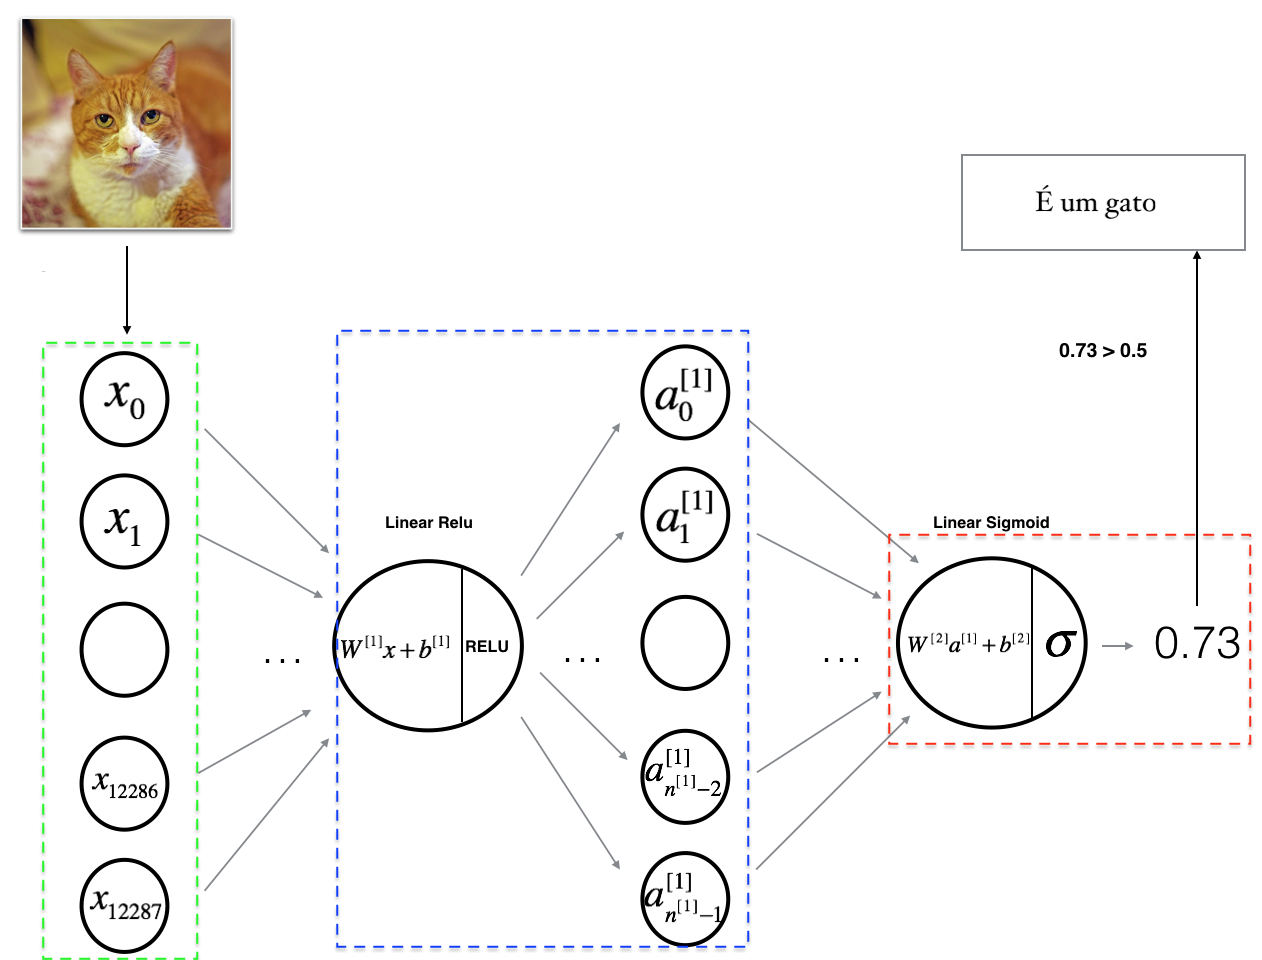
<caption><center> Figura: Rede neural com 2 camadas. <br> Resumo do modelo: ***ENTRADA -> LINEAR -> RELU -> LINEAR -> SIGMOID -> SAIDA***. </center></caption>


Custo depois da iteração 0: 0.693147
Custo depois da iteração 100: 0.678011
Custo depois da iteração 200: 0.667600
Custo depois da iteração 300: 0.660422
Custo depois da iteração 400: 0.655458
Custo depois da iteração 500: 0.652014
Custo depois da iteração 600: 0.649616
Custo depois da iteração 700: 0.647942
Custo depois da iteração 800: 0.646770
Custo depois da iteração 900: 0.645947
Custo depois da iteração 1000: 0.645368
Custo depois da iteração 1100: 0.644961
Custo depois da iteração 1200: 0.644673
Custo depois da iteração 1300: 0.644469
Custo depois da iteração 1400: 0.644325
Custo depois da iteração 1500: 0.644223
Custo depois da iteração 1600: 0.644151
Custo depois da iteração 1700: 0.644100
Custo depois da iteração 1800: 0.644063
Custo depois da iteração 1900: 0.644037
Custo depois da iteração 2000: 0.644019
Custo depois da iteração 2100: 0.644006
Custo depois da iteração 2200: 0.643997
Custo depois da iteração 2300: 0.643990
Custo depois da iteração 2400: 0.643985


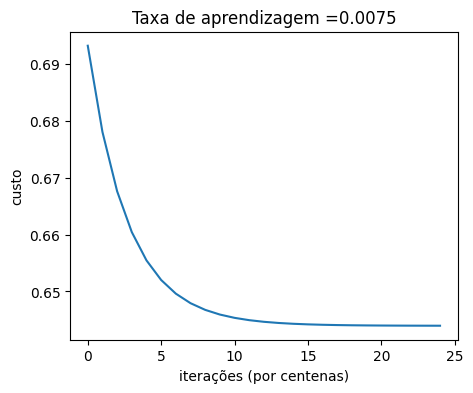

In [60]:
# Executar uma rede de 2 camadas
camada_dims = [12288, 7, 1]

treino_x_redimensionado = treino_x.reshape(treino_x.shape[0], -1).T

# Treine a rede
parametros = treinar_modelo_com_L_camadas(treino_x_redimensionado, treino_y, camada_dims, num_iter = 2500, print_custo=True)

#### Função para utilizar do modelo treinado para predizer (8pt):

In [61]:
def predicao(treino_x,treino_y,teste_x,teste_y):
    '''
    Prediz se o rótulo é 0 ou 1 usando os parâmetros de aprendizagem (w,b) da regressão logística

    Entrada:
      w -- pesos, de tamanho (num_px * num_px * 3, 1)
      b -- bias, um escalar
      X -- dados de treinamentos de tamanho (num_px * num_px * 3, número de exemplos)
    Saída:
      Y_pred -- um vetor contendo todas as predições (0/1) para os dados X
    '''
    m_treino = treino_x.shape[1] # número de exemplos
    m_teste = teste_x.shape[1]
    Y_pred_treino = np.zeros((1,m_treino)) # inicialize o vetor de predições
    Y_pred_teste = np.zeros((1,m_teste))
    A_treino, C_treino = L_modelo_forward(treino_x, parametros) # ToDo: Fazer o forward dos dados pelo modelo
    A_teste, C_teste = L_modelo_forward(teste_x, parametros) # ToDo: Fazer o forward dos dados pelo modelo

    for i in range(A_teste.shape[1]):
        Y_pred_teste[0,i] = 1 if A_teste[0, i] > 0.5 else 0
    assert(Y_pred_teste.shape == (1, m_teste))

    for i in range(A_treino.shape[1]):
      Y_pred_treino[0,i] = 1 if A_treino[0, i] > 0.5 else 0
    assert(Y_pred_treino.shape == (1, m_treino))

    soma_treino = 0
    for i in range(Y_pred_treino.size):
      if Y_pred_treino[0,i] == treino_y[0,i]:
        soma_treino += 1

    print(f'Acuracia do treino: {(soma_treino/Y_pred_treino.size)*100}%')

    soma_teste = 0
    for i in range(Y_pred_teste.size):
      if Y_pred_teste[0,i] == teste_y[0,i]:
        soma_teste += 1
    print(f' Acuracia do teste: {(soma_teste/Y_pred_teste.size)*100}%')

    return Y_pred_treino,Y_pred_teste

Agora testaremos o modelo treinado. O resultado esperado:

```
    Acurácia no treino: 0.6555023923444976
    Acurácia no teste: 0.34
```


In [65]:
treino_x_redimensionado = treino_x.reshape(treino_x.shape[0], -1).T
teste_x_redimensionado = teste_x.reshape(teste_x.shape[0], -1).T

# Predição da rede
Y_pred_treino,Y_pred_teste = predicao(treino_x_redimensionado,treino_y,teste_x_redimensionado,teste_y)

Acuracia do treino: 65.55023923444976%
 Acuracia do teste: 34.0%


### Testando um modelo mais profundo com quatro camadas



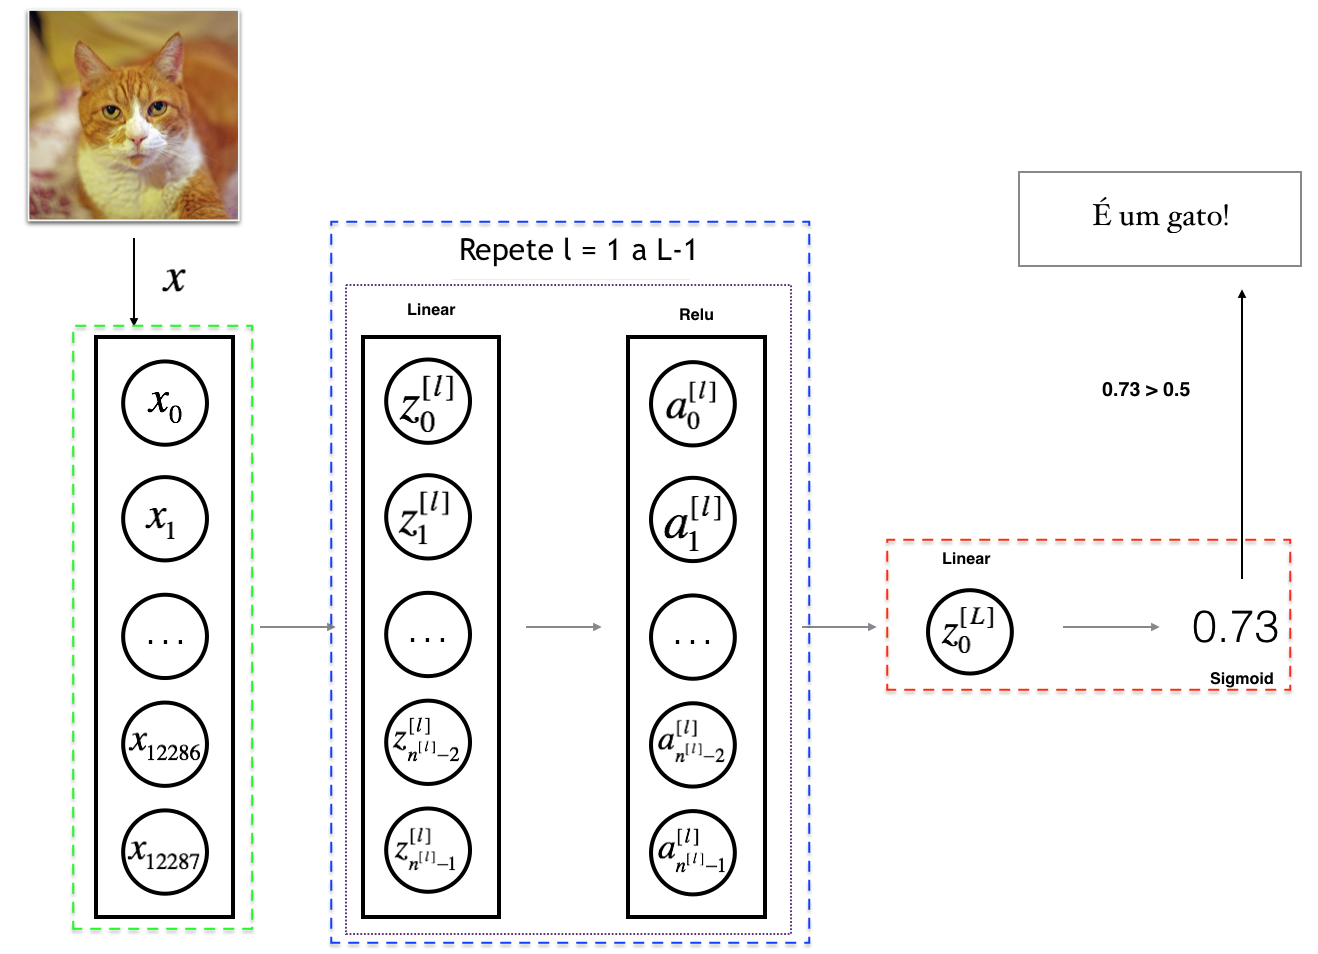
<caption><center> Figura: Rede neural com L camadas. <br> Resumo do modelo: ***ENTRADA -> LINEAR -> RELU -> LINEAR -> SIGMOID -> SAIDA***. </center></caption>

Custo depois da iteração 0: 0.693147
Custo depois da iteração 100: 0.678011
Custo depois da iteração 200: 0.667600
Custo depois da iteração 300: 0.660422
Custo depois da iteração 400: 0.655458
Custo depois da iteração 500: 0.652014
Custo depois da iteração 600: 0.649616
Custo depois da iteração 700: 0.647942
Custo depois da iteração 800: 0.646770
Custo depois da iteração 900: 0.645947
Custo depois da iteração 1000: 0.645368
Custo depois da iteração 1100: 0.644961
Custo depois da iteração 1200: 0.644673
Custo depois da iteração 1300: 0.644469
Custo depois da iteração 1400: 0.644325
Custo depois da iteração 1500: 0.644223
Custo depois da iteração 1600: 0.644151
Custo depois da iteração 1700: 0.644100
Custo depois da iteração 1800: 0.644063
Custo depois da iteração 1900: 0.644037
Custo depois da iteração 2000: 0.644019
Custo depois da iteração 2100: 0.644006
Custo depois da iteração 2200: 0.643997
Custo depois da iteração 2300: 0.643990
Custo depois da iteração 2400: 0.643985


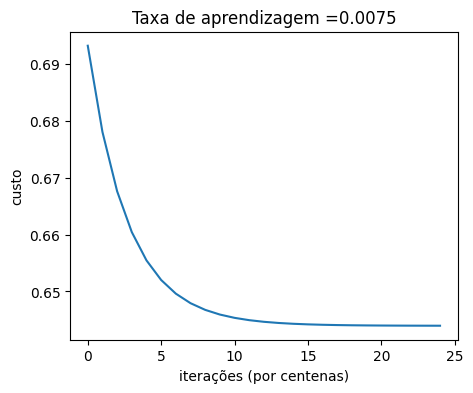

In [67]:
# Executar uma rede de 4 camada
camadas_dims = [12288, 20, 7, 5, 1]

treino_x_redimensionado = treino_x.reshape(treino_x.shape[0], -1).T

## Treine a rede
parametros = treinar_modelo_com_L_camadas(treino_x_redimensionado, treino_y, camadas_dims, num_iter = 2500, print_custo=True)

In [70]:
treino_x_redimensionado = treino_x.reshape(treino_x.shape[0], -1).T
teste_x_redimensionado = teste_x.reshape(teste_x.shape[0], -1).T

# Predição da rede
Y_pred_treino,Y_pred_teste = predicao(treino_x_redimensionado,treino_y,teste_x_redimensionado,teste_y)

Acuracia do treino: 65.55023923444976%
 Acuracia do teste: 34.0%


#### Pergunta (2pt)


ToDo: Este resultado foi melhor ou pior do que com duas camadas (última prática)? Tente explicar os motivos.

```
  Temos uma acurácia menor que na prática passada, mas isso não é um fator ruim, pois quer dizer que este modelo pode
  modelar relações mais complexas de dados, ou seja, maior capacidade de generalização, podendo identificar melhor
  figuras que não estavam no treinamento e "resolvendo" um pouco do overfitting
```